In [101]:
# import packages
import pandas as pd
import numpy as np
import scipy as spy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = (7, 5)
from ftp_functions import * #listFtp(), downloadFile(), uploadFile(), password required.

In [93]:
PATH = '../data/'

In [112]:
df_data_nationales = pd.read_pickle(PATH+'df_data_nationales.pkl')
df_data_nationales.dropna(inplace=True)

# df_prod_wind_solar =  pd.read_pickle(PATH+'solar_wind_2012_2019.pkl')
# df_prod_wind_solar.fillna(value=0,inplace=True) #not sure if best method, maybe backfill instead?

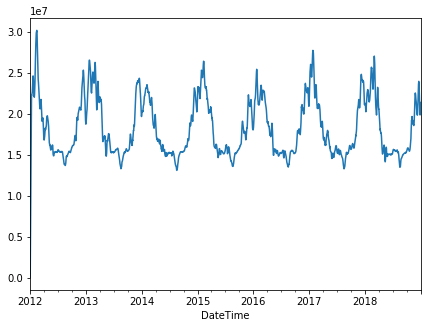

In [113]:
df_data_nationales.Consommation.rolling('7D').sum().plot();

In [299]:
def modelConstantsAnnee(df,annee):
    """ Return alpha = Rapport puissance eolien hiver sur ete. beta pour solaire, gamma pour hydro."""
    conso_max = df.loc[annee].Consommation.rolling('7D').sum().max()
    week_max = df.loc[annee].Consommation.rolling('7D').sum()[df.loc[annee].Consommation.rolling('7D').sum() == conso_max].index[0]
    if week_max.month >1:
        month = week_max.month
        month_before = week_max.replace(month=month-1)
        month_after = week_max.replace(month=month+1)
    else :
        month_before = week_max.replace(month=12)
        month_before = month_before.replace(year=int(annee)-1)
        month_after = week_max.replace(month=2)        
    prod_solaire_hiver = df.loc[month_before:month_after].Solaire.cumsum()[-1]
    prod_eolien_hiver = df.loc[month_before:month_after].Eolien.cumsum()[-1]
    prod_hydraulique_hiver = df.loc[month_before:month_after].Hydraulique.cumsum()[-1]
    
    conso_min = df.loc[annee].Consommation.rolling('7D').sum()[1000:].min() #slicing needed to avoid beginning of rolling.
    week_min = df.loc[annee].Consommation.rolling('7D').sum()[df.loc[annee].Consommation.rolling('7D').sum() == conso_min].index[0]
    month = week_min.month
    month_before = week_min.replace(month=month-1)
    month_after = week_min.replace(month=month+1)
    prod_solaire_ete = df.loc[month_before:month_after].Solaire.cumsum()[-1]
    prod_eolien_ete = df.loc[month_before:month_after].Eolien.cumsum()[-1]
    prod_hydraulique_ete = df.loc[month_before:month_after].Hydraulique.cumsum()[-1]
    
    return prod_eolien_hiver/prod_eolien_ete, prod_solaire_hiver/prod_solaire_ete, prod_hydraulique_hiver/prod_hydraulique_ete

In [312]:
def modelConstantsDistri(df):
    annee_min = df.index[0].year
    annee_max = df.index[-1].year
    
    constants = pd.DataFrame()
    for annee in range(annee_min,annee_max+1):        
        constants[str(annee)] = modelConstantsAnnee(df_data_nationales,str(annee))
    
    constants.rename(index={0:'alpha',1:'beta',2:'gamma'},inplace=True)
    mean=constants.mean(axis=1)
    std=constants.std(axis=1)
    constants['Mean']=mean
    constants['std']=std
    
    return constants

In [327]:
constants = modelConstantsDistri(df)
constants

,2012,2013,2014,2015,2016,2017,2018,Mean,std
alpha,1.429102,2.139531,2.501920,1.558292,2.917360,1.229051,2.419841,2.027871,0.632345
beta,0.386546,0.309581,0.322930,0.430331,0.319739,0.396955,0.505590,0.381667,0.071256
gamma,1.421105,1.451644,1.374105,1.846873,1.421057,1.439904,1.784277,1.534138,0.194607


In [328]:
constants = constants.apply(lambda x:round(x,2))
print(constants.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  2012 &  2013 &  2014 &  2015 &  2016 &  2017 &  2018 &  Mean &   std \\
\midrule
alpha &  1.43 &  2.14 &  2.50 &  1.56 &  2.92 &  1.23 &  2.42 &  2.03 &  0.63 \\
beta  &  0.39 &  0.31 &  0.32 &  0.43 &  0.32 &  0.40 &  0.51 &  0.38 &  0.07 \\
gamma &  1.42 &  1.45 &  1.37 &  1.85 &  1.42 &  1.44 &  1.78 &  1.53 &  0.19 \\
\bottomrule
\end{tabular}

